In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [71]:
import statistics
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from scipy import stats
import chart_studio.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *


In [72]:
df = pd.read_csv('PCC.individual.project.data.csv')

In [73]:
data = df.loc[df['STUDYID'] != 'ASC']


In [74]:
test_data = df.loc[df['STUDYID'] == 'ASC']


In [75]:
def get_risk(patient):
    if patient.death == 1 and patient.time < 365:
        # Patient is high risk
        return 1
    # WASpatient.death == 0 and patient.time > 730:
    elif patient.time > 730:
        # Patient is low risk
        return 0
    else:
        # Patient needs to be dropped, insufficient data
        return 'drop'


In [76]:
data['high_risk'] = data.apply(get_risk, axis=1)
data = data.loc[lambda patient: patient.high_risk != 'drop']

<ipython-input-76-685f43374b07>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [77]:
data = data.drop(['time','death'],axis=1)

In [78]:
test_data = test_data.drop(['time', 'death'], axis=1)


In [79]:
data = data.drop(['STUDYID','RPT'],axis=1)

In [80]:
test_data = test_data.drop(['STUDYID', 'RPT'], axis=1)


In [164]:
data

,BMI,HEIGHTBL,WEIGHTBL,ALP,ALT,AST,CA,CREAT,HB,LDH,...,RaceAsian,RaceBlack,RaceOther,RaceWhite,RegionAsia,RegionEastEuro,RegionNorthAmer,RegionSouthAmer,RegionWestEuro,high_risk
479,27.9,169.0,79.6,4.127134,2.197225,2.772589,2.44,4.290459,12.9,5.442418,...,0,0,0,1,0,0,0,0,1,1
482,33.2,161.5,85.1,5.700444,5.141664,5.793014,1.80,5.420535,11.7,6.232448,...,0,0,0,1,0,0,1,0,0,1
483,25.2,167.9,67.6,4.406719,2.639057,3.044522,2.30,4.663439,11.4,5.129899,...,0,0,0,1,0,0,1,0,0,1
499,23.0,182.0,75.7,6.383507,2.639057,3.295837,2.25,4.060443,11.7,5.700444,...,0,0,0,1,0,0,0,0,0,1
503,22.5,170.0,65.0,6.877296,3.295837,3.761200,1.98,4.127134,9.7,6.226537,...,0,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1590,26.4,175.0,81.0,4.564348,2.772589,2.890372,2.13,4.125197,13.5,5.243709,...,0,0,0,1,0,1,0,0,0,0
1594,29.6,167.0,82.5,4.836282,3.135494,3.258097,2.25,4.664194,12.1,5.395179,...,0,0,0,1,0,1,0,0,0,0
1596,31.0,175.0,95.0,4.709530,2.944439,2.995732,2.25,4.317488,10.4,5.364646,...,0,0,0,1,0,1,0,0,0,0
1597,26.0,190.0,94.0,4.143135,2.995732,3.135494,2.40,4.663439,11.6,5.327408,...,0,0,0,1,0,1,0,0,0,0


In [81]:
X = data.drop(['high_risk'], axis=1).values
y = data['high_risk'].values


In [82]:
y = y.astype('int')


In [83]:
from sklearn.model_selection import train_test_split


In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=101)


# Support Vector Machine

In [85]:
from sklearn.svm import SVC


## First Attempt w/ Regular Params

In [86]:
model = SVC()

In [87]:
model.fit(X_train,y_train)

SVC()

In [88]:
predictions = model.predict(X_test)

In [89]:
from sklearn.metrics import classification_report, confusion_matrix


In [90]:
print(confusion_matrix(y_test, predictions))


[[81  0]
 [72  3]]


In [91]:
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.53      1.00      0.69        81
           1       1.00      0.04      0.08        75

    accuracy                           0.54       156
   macro avg       0.76      0.52      0.38       156
weighted avg       0.76      0.54      0.40       156



## Second Try: w/ Best Params

In [92]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [
    1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}


In [93]:
from sklearn.model_selection import GridSearchCV


In [94]:
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

In [95]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.587 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.587 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.587 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.587 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.581 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.587 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.587 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.587 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.587 total time=   0.1s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.581 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.587 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [96]:
grid.best_params_

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}

In [97]:
grid.best_estimator_

SVC(C=10, gamma=0.0001)

In [98]:
grid_predictions = grid.predict(X_test)

In [99]:
print(confusion_matrix(y_test, grid_predictions))
print('\n')
print(classification_report(y_test, grid_predictions))

[[67 14]
 [44 31]]


              precision    recall  f1-score   support

           0       0.60      0.83      0.70        81
           1       0.69      0.41      0.52        75

    accuracy                           0.63       156
   macro avg       0.65      0.62      0.61       156
weighted avg       0.64      0.63      0.61       156



# Logistic Regression Model

In [100]:
from sklearn.linear_model import LogisticRegression

In [101]:
logModel = LogisticRegression(solver='liblinear')

In [102]:
logModel.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [103]:
log_predictions = logModel.predict(X_test)


In [104]:
print(classification_report(y_test, log_predictions))
print('\n')
print(confusion_matrix(y_test, log_predictions))

              precision    recall  f1-score   support

           0       0.61      0.73      0.66        81
           1       0.63      0.49      0.55        75

    accuracy                           0.62       156
   macro avg       0.62      0.61      0.61       156
weighted avg       0.62      0.62      0.61       156



[[59 22]
 [38 37]]


# Random Forest Classifier

In [105]:
from sklearn.ensemble import RandomForestClassifier

In [106]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [107]:
rfc_pred = rfc.predict(X_test)

In [108]:
print(classification_report(y_test, rfc_pred))
print('\n')
print(confusion_matrix(y_test, rfc_pred))


              precision    recall  f1-score   support

           0       0.66      0.81      0.73        81
           1       0.73      0.55      0.63        75

    accuracy                           0.69       156
   macro avg       0.70      0.68      0.68       156
weighted avg       0.69      0.69      0.68       156



[[66 15]
 [34 41]]


In [109]:
rfc2 = RandomForestClassifier(n_estimators=300)
rfc2.fit(X_train, y_train)


RandomForestClassifier(n_estimators=300)

In [110]:
rfc2_pred = rfc2.predict(X_test)

In [111]:
print(classification_report(y_test, rfc2_pred))
print('\n')
print(confusion_matrix(y_test, rfc2_pred))


              precision    recall  f1-score   support

           0       0.67      0.84      0.75        81
           1       0.76      0.56      0.65        75

    accuracy                           0.71       156
   macro avg       0.72      0.70      0.70       156
weighted avg       0.72      0.71      0.70       156



[[68 13]
 [33 42]]


# Cross Validations

In [112]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [113]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)


In [114]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)

## Support Vector Machine

In [115]:
results = cross_val_score(SVC(), X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 57.87% (3.13%)


Baseline: 63.36% (0.94%); NOW: 93.82% (0.15%); 57.87 (3.13)

### Best params

In [116]:
results = cross_val_score(SVC(C=10, gamma=0.0001), X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Baseline: 63.62% (5.74%)


Baseline: 71.31% (3.51%);NOW: 93.82% (0.15%); 63.62 (5.74)

## Logistic Regression

In [117]:
results = cross_val_score(LogisticRegression(solver='liblinear'), X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Baseline: 72.13% (5.08%)


Baseline: 79.66% (5.41%); NOW: 91.40% (2.89%); 72.13(5.08)

## Random Forest

In [118]:
results = cross_val_score(RandomForestClassifier(n_estimators=100), X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Baseline: 77.02% (7.54%)


RF100: 81.05% (7.44%); 93.82% (0.15%); 77.02 (7.54)

In [119]:
results = cross_val_score(RandomForestClassifier(
    n_estimators=300), X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Baseline: 76.38% (4.99%)


RF300: 81.4% (5.64%); NOW: 93.82% (0.15%); 76.38(4.99)

In [121]:
len(X)

470

# Final Model

In [147]:
rfc_f = RandomForestClassifier(n_estimators=100)


In [148]:
rfc_f.fit(X, y)

RandomForestClassifier()

In [149]:
# test_data = test_data.drop(['pred','time','death'], axis=1)
test_data

,BMI,HEIGHTBL,WEIGHTBL,ALP,ALT,AST,CA,CREAT,HB,LDH,...,RaceOther,RaceWhite,RegionAsia,RegionEastEuro,RegionNorthAmer,RegionSouthAmer,RegionWestEuro,pred,time,death
0,28.7000,172.72,85.73000,5.733341,2.944439,3.258097,2.42,4.477337,11.9,5.187386,...,0,0,0,0,0,0,0,0,585,1
1,25.3000,171.80,74.80000,6.269096,2.708050,3.295837,1.95,4.262680,12.6,5.379897,...,0,1,0,0,0,0,0,1,495,1
2,26.2000,167.90,73.90000,5.068904,2.639057,2.890372,2.27,4.663439,11.5,5.590987,...,0,1,0,0,0,0,0,1,167,1
3,26.9915,166.70,83.50879,4.812184,3.761200,3.688879,2.20,4.820282,11.5,5.257495,...,0,1,0,0,0,0,0,1,161,1
4,46.5000,175.60,143.30000,3.496508,2.944439,3.258097,2.35,4.262680,13.0,5.123964,...,0,1,0,0,0,0,0,1,575,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,29.1000,168.00,82.00000,4.406719,2.772589,2.890372,2.31,4.356709,12.7,4.969813,...,0,1,0,0,0,0,0,0,231,0
472,22.6000,172.00,67.00000,4.595120,3.135494,3.496508,2.25,4.532599,12.0,5.594711,...,0,1,0,0,0,0,0,1,359,0
473,25.0000,179.00,80.00000,6.622736,2.708050,3.218876,2.07,4.127134,12.5,5.891644,...,0,1,0,0,0,0,0,1,343,0
474,31.2000,164.00,84.00000,6.411818,3.784190,3.367296,2.15,3.891820,10.8,5.697093,...,0,1,0,0,0,0,0,1,104,1


In [150]:
f_pred = rfc_f.predict(test_data.drop(['pred','time','death'],axis=1))

In [151]:
sum(f_pred)

153

In [152]:
test_data['pred'] = f_pred

# Variable Importances

In [153]:
import time
import numpy as np

start_time = time.time()
importances = rfc_f.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rfc_f.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.046 seconds


(101,)


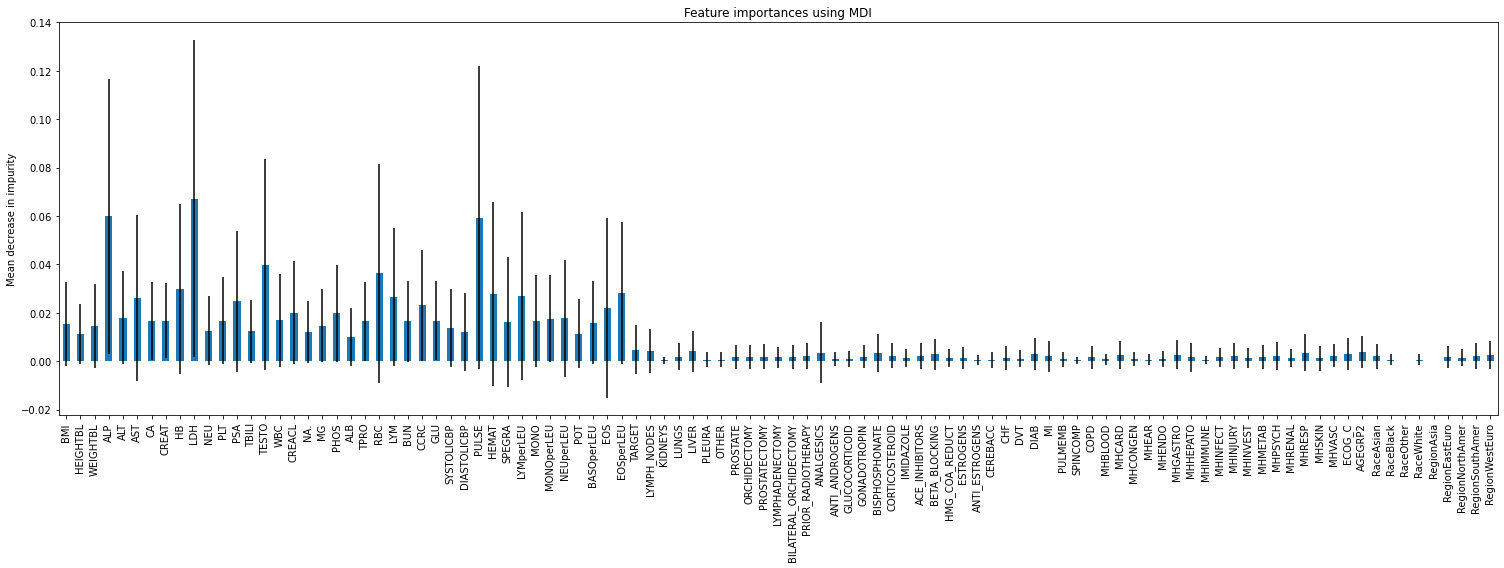

In [154]:
## NEW ONE
feature_names = data.columns.drop('high_risk')
print(feature_names.shape)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(21, 8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
filename = "/Users/belalelsiesy/Desktop/Data Analysis/featureImportance/mdi2_newdata.png"
plt.savefig(filename, transparent=True)
fig.tight_layout()


In [155]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    rfc_f, X, y, n_repeats=10, random_state=42, n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)


Elapsed time to compute the importances: 18.499 seconds


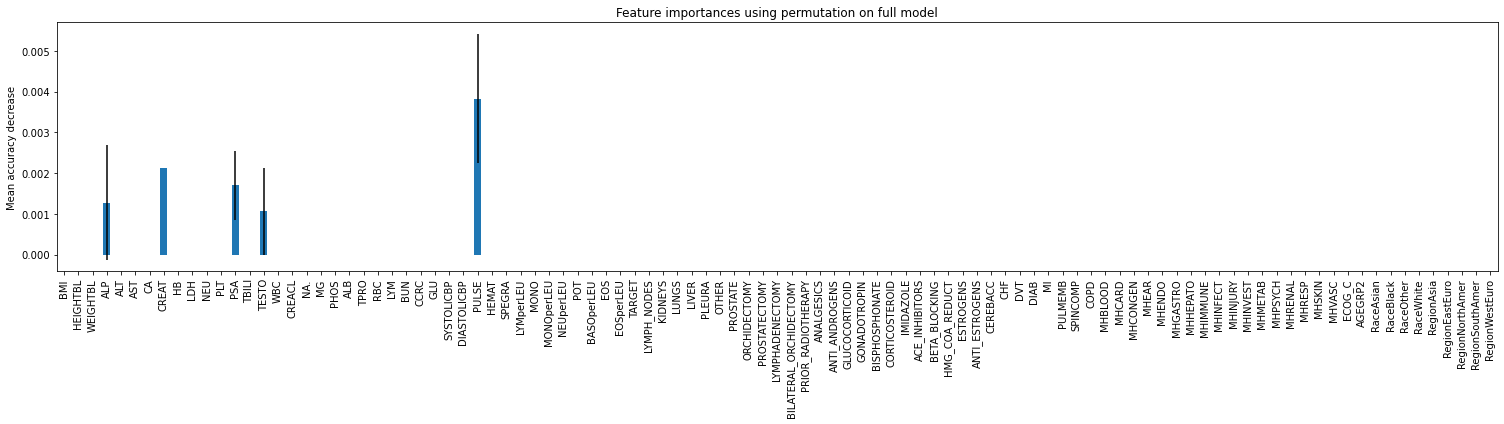

In [156]:
## NEW ONE
fig, ax = plt.subplots(figsize=(21, 6))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
filename = "/Users/belalelsiesy/Desktop/Data Analysis/featureImportance/permutation_newdata.png"
plt.savefig(filename, transparent=True)
plt.show()


In [157]:
kmf = KaplanMeierFitter()

In [158]:
test_data['time'] = df.loc[df['STUDYID'] == 'ASC']['time']
test_data['death'] = df.loc[df['STUDYID'] == 'ASC']['death']

In [159]:
low_risk = test_data.loc[test_data['pred'] == 0]
high_risk = test_data.loc[test_data['pred'] == 1]


In [160]:
df['high_risk'] = df.apply(get_risk, axis=1)


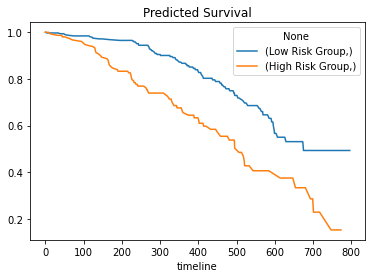

In [163]:
T = low_risk['time']
C = low_risk['death']

T2 = high_risk['time']
C2 = high_risk['death']

ax = plt.subplot(111)

kmf.fit(T, event_observed=C, label=['Low Risk Group'])
kmf.survival_function_.plot(ax=ax)
kmf.fit(T2, event_observed=C2, label=['High Risk Group'])
kmf.survival_function_.plot(ax=ax)

plt.title('Predicted Survival')
filename = "/Users/belalelsiesy/Desktop/Data Analysis/featureImportance/kmplot1_white.jpg"
plt.savefig(filename)
kmf2 = plt.gcf()


## Log Rank Test

In [170]:
import dataframe_image as dfi
from lifelines.statistics import logrank_test


In [173]:

results = logrank_test(T, T2, event_observed_A=C, event_observed_B=C2)
results.print_summary()
print("p: ", results.p_value)        
print("test statistic: ", results.test_statistic)  # 0.0872


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          27.53 <0.005     22.62

p:  1.5505971524188012e-07
test statistic:  27.525215013181466
